In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import tensorflow as tf
import cv2
from google.cloud import storage
import io
from PIL import Image

import sys, os, inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(2,parentdir) 
from model.image_utils import *

In [2]:
bucket_id = 'inpainting-final-project'
path = 'images/Cars/cars_train/'

In [3]:
images = load_images_from_bucket(bucket_id, path)

In [4]:
#check the number of images 
len(images)

8126

In [5]:
#show an example image matrix 
images[0]

array([[[-0.34117647, -0.2       , -0.16862745],
        [-0.2627451 , -0.12156863, -0.09019608],
        [-0.45098039, -0.27843137, -0.23921569],
        ...,
        [ 0.9372549 ,  0.96862745,  0.97647059],
        [ 0.97647059,  1.        ,  1.        ],
        [ 0.9372549 ,  0.98431373,  0.98431373]],

       [[-0.34117647, -0.2       , -0.16862745],
        [-0.23137255, -0.09019608, -0.05882353],
        [-0.30196078, -0.15294118, -0.10588235],
        ...,
        [ 0.91372549,  0.98431373,  0.97647059],
        [ 0.90588235,  0.97647059,  0.96862745],
        [ 0.89803922,  0.94509804,  0.94509804]],

       [[-0.27843137, -0.1372549 , -0.11372549],
        [-0.35686275, -0.21568627, -0.18431373],
        [-0.31764706, -0.18431373, -0.1372549 ],
        ...,
        [ 0.89803922,  0.96862745,  0.96862745],
        [ 0.8745098 ,  0.95294118,  0.94509804],
        [ 0.90588235,  0.95294118,  0.95294118]],

       ...,

       [[ 0.35686275,  0.37254902,  0.28627451],
        [ 0

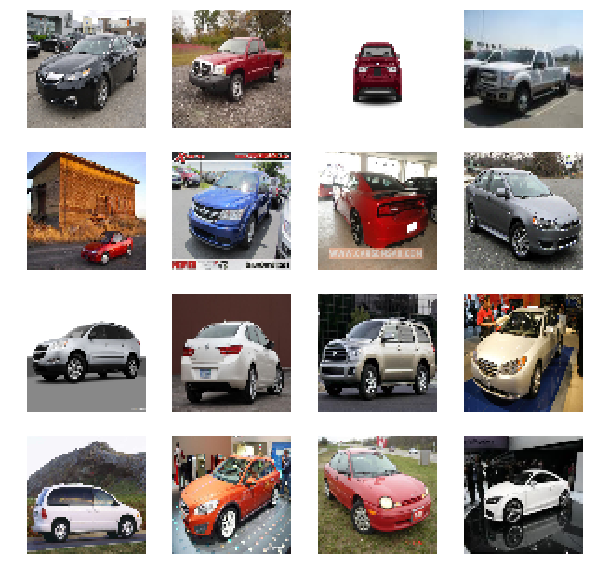

In [6]:
#visualize the preprocessed images

#convert the images back to 0-255 for visualization 

images2 = [cv2.normalize(i, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F).astype(np.uint8) for i in images]
img_col = ImageCollector(np.asarray(images2))
img_col.show(np.asarray(images2))

In [7]:
images_with_noise = add_noise(images, 1, 5)

In [8]:
#train the model - generator and discriminator 

from model.dcgan import DCGAN

tf.reset_default_graph()
dcgan = DCGAN(batch_size=64,
              z_dim=100,
              model_name='DCGAN',
              data_source='Cars',
              z_dist='norm')
dcgan.train(images_with_noise, learning_rate=0.0001, iters=1500)

conv_0_(64, 4, 4, 512)
conv_0_norm_(64, 4, 4, 512)
conv_0_relu_(64, 4, 4, 512)
conv_1_(64, 8, 8, 256)
conv_1_norm_(64, 8, 8, 256)
conv_1_relu_(64, 8, 8, 256)
conv_2_(64, 16, 16, 128)
conv_2_norm_(64, 16, 16, 128)
conv_2_relu_(64, 16, 16, 128)
conv_3_(64, 32, 32, 64)
conv_3_norm_(64, 32, 32, 64)
conv_3_relu_(64, 32, 32, 64)
conv_4_(64, 64, 64, 3)
(64, 64, 64, 3)
(64, 64, 64, 3)
Building my DCGAN
X_train size 8126
new size 8126
Step: 0, D_loss: 1.4900108575820923, G_loss: 0.4192015528678894
Step: 100, D_loss: 0.1391441375017166, G_loss: 5.675961494445801
Step: 200, D_loss: 1.1036996841430664, G_loss: 7.1565351486206055
Step: 300, D_loss: 0.3170166313648224, G_loss: 3.4886510372161865
Step: 400, D_loss: 0.3043823838233948, G_loss: 2.652005195617676
Step: 500, D_loss: 0.5153153538703918, G_loss: 2.66233491897583
Step: 600, D_loss: 0.22629526257514954, G_loss: 3.0899269580841064
Step: 700, D_loss: 0.47268441319465637, G_loss: 2.3413496017456055
Step: 800, D_loss: 0.43665051460266113, G_loss

In [9]:
# show the graph
from model.cnn_jupyter_tensorboard import show_graph 
tf.reset_default_graph()
with tf.Session() as sess:
    saver = tf.train.import_meta_graph('../Cars/checkpoints/DCGAN.ckpt.meta')
    graph = tf.get_default_graph()
    show_graph(graph)
    

In [20]:
# tf.train.get_checkpoint_state('checkpoints')

In [19]:
# checkpoint = tf.train.latest_checkpoint('checkpoints')

In [18]:
# #Step 1 
# #import the model metagraph
# saver = tf.train.import_meta_graph('../Cars/checkpoints/DCGAN.ckpt.meta', clear_devices=True)
# #make that as the default graph
# graph = tf.get_default_graph()
# input_graph_def = graph.as_graph_def()
# sess = tf.Session()

# sess.run(tf.global_variables_initializer())
# #now restore the variables
# saver.restore(sess, "../Cars/checkpoints/DCGAN.ckpt")


In [17]:
# #Step 2
# # Find the output name
# graph = tf.get_default_graph()
# for n in graph.as_graph_def().node: 
#       print (n.name)

In [16]:
# #Step 3
# from tensorflow.python.platform import gfile
# from tensorflow.python.framework import graph_util

# output_node_names=[n.name for n in graph.as_graph_def().node]

# # [v.op.name for v in tf.global_variables()] 

# output_graph_def = graph_util.convert_variables_to_constants(
#         sess, # The session
#         input_graph_def, # input_graph_def is useful for retrieving the nodes 
#         output_node_names)    



In [14]:
# #Step 4
# #output folder
# output_fld ='./'
# #output pb file name
# output_model_file = 'model.pb'
# from tensorflow.python.framework import graph_io
# #write the graph
# graph_io.write_graph(output_graph_def, output_fld, output_model_file, as_text=False)

In [15]:
# graph, graph_def = loadpb('./model.pb',model_name='DCGAN' )

In [ ]:
# with tf.Session() as sess:
#     loader = tf.train.import_meta_graph('../Cars/checkpoints/DCGAN.ckpt.meta')
#     loader.restore(sess, '../Cars/checkpoints/DCGAN.ckpt')
#     graph2 = tf.get_default_graph()
#     for op in graph2.get_operations():
#         print(op.name)

In [ ]:
# graph2.get_tensor_by_name('inputs/z:0')

In [13]:
# import tensorflow as tf

# meta_path = '../Cars/checkpoints/DCGAN.ckpt.meta' # Your .meta file
# tf.train.get_checkpoint_state('checkpoints')

# with tf.Session() as sess:
#     sess.run(tf.global_variables_initializer())

#     # Restore the graph
   
#     saver = tf.train.import_meta_graph(meta_path)

#     # Load weights
#     saver.restore(sess, '../Cars/checkpoints/DCGAN.ckpt')

#     # Output nodes
#     output_node_names =[n.name for n in tf.get_default_graph().as_graph_def().node]

#     # Freeze the graph
#     frozen_graph_def = tf.graph_util.convert_variables_to_constants(
#         sess,
#         sess.graph_def,
#         output_node_names)

#     # Save the frozen graph
#     with open('test.pb', 'wb') as f:
#         f.write(frozen_graph_def.SerializeToString())